[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Kernel SVM

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 16/03/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0039ClassifierKernelSVM.ipynb)

In [9]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import make_classification
from sklearn.svm import SVC

# Image Processing

# Machine Learning

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [10]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [11]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

In [12]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotBinaryClassData, PlotDecisionBoundaryClosure


In [13]:
# General Auxiliary Functions

def IsStrFloat(inStr: any) -> bool:
    #Support None input
    if inStr is None: 
        return False
    try:
        float(inStr)
        return True
    except ValueError:
        return False


## Kernel Trick

The Kernel Trick is mostly a way to generate features implicitly in a way which is compute efficient.  
While it is mostly used in the context of _Support Vector Machine_ (SVM) it is useful in many other algorithms as well.

In [14]:
# Parameters

# Data Generation
numSamples      = 400
numFeatures     = 2 #<! Number of total features
numInformative  = 2 #<! Number of informative features
numRedundant    = 0 #<! Number of redundant features
numRepeated     = 0 #<! Number of repeated features
numClasses      = 2 #<! Number of classes
flipRatio       = 0.05 #<! Number of random swaps

# Data Visualization
numGridPts = 500


## Generate / Load Data

The data will be generated using SciKit Learn's [`make_classification()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function.


In [15]:
# Generate Data 

mX, vY = make_classification(n_samples = numSamples, n_features = numFeatures, n_informative = numInformative, 
                             n_redundant = numRedundant, n_repeated = numRepeated, n_classes = numClasses, flip_y = flipRatio)


# Decision Boundary Plotter
PlotDecisionBoundary = PlotDecisionBoundaryClosure(numGridPts, mX[:, 0].min(), mX[:, 0].max(), mX[:, 1].min(), mX[:, 1].max())

print(f'The features data shape: {mX.shape}')
print(f'The labels data shape: {vY.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

The features data shape: (400, 2)
The labels data shape: (400,)
The unique values of the labels: [0 1]


### Plot Data

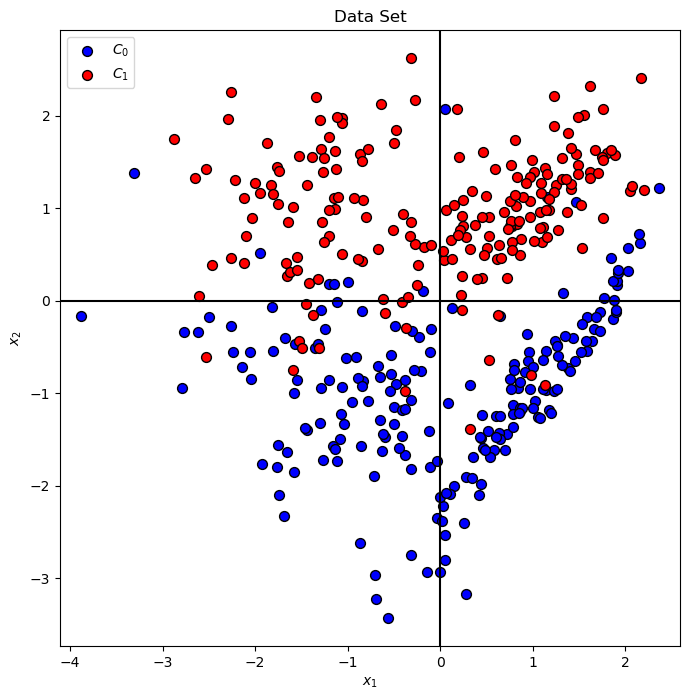

In [16]:
# Plot the Data

hA = PlotBinaryClassData(mX, vY, axisTitle = 'Data Set')
hA.set_xlabel('${x}_{1}$')
hA.set_ylabel('${x}_{2}$')

plt.show()

## Train a Kernel SVM Classifier

The SciKit Learn's Kernel SVM classifier has 4 kernel options: `linear`, `poly`, `rbf`, `sigmoid` and manual.  
The 2 most used are:

$$
\begin{aligned}
& \text{The Polynomial Kernel:} \; && K \left( \boldsymbol{x}_{i},\boldsymbol{x}_{j} \right) = \left(1+\boldsymbol{x}_{i}^{T}\boldsymbol{x}_{j}\right)^{d} \\
& \text{The Gaussian Kernel (RBF):} \; && K \left( \boldsymbol{x}_{i},\boldsymbol{x}_{j} \right) = \exp\left(-\gamma\left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}^{2}\right)=\exp\left(-\frac{1}{2\sigma^{2}}\left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}^{2}\right)
\end{aligned}
$$

* <font color='brown'>(**#**)</font> See [SciPy's Kernel functions _Mathematical formulations_](https://scikit-learn.org/stable/modules/svm.html#kernel-functions).
* <font color='brown'>(**#**)</font> The most commonly used kernel is the _RBF_ kernel.  
  It can be shown that it is equivalent of potentially infinite polynomial degree where the actual degree can be set using the $\sigma$ parameter.
* <font color='brown'>(**#**)</font> In case the features are well engineered one can try well tuned linear model. Preferably using `LinearSVC` which is more efficient with large dataset.

In [17]:
# Kernel SVM Plotting Function

def PlotKernelSvm( C: float, kernelType: str, polyDeg: int, γ: float, mX: np.ndarray, vY: np.ndarray ) -> None:
    if IsStrFloat(γ):
        γ = float(γ)
    # Train the classifier
    oSvmCls = SVC(C = C, kernel = kernelType, degree = polyDeg, gamma = γ).fit(mX, vY) #<! Training on the data, coef0 for bias
    clsScore = oSvmCls.score(mX, vY)
    
    hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
    hA = PlotDecisionBoundary(oSvmCls.predict, hA = hA)
    hA = PlotBinaryClassData(mX, vY, hA = hA, axisTitle = f'Classifier Decision Boundary, Accuracy = {clsScore:0.2%}')

    hA.set_xlabel('${x}_{1}$')
    hA.set_ylabel('${x}_{2}$')

In [18]:
# LAmbda Function for Kernel SVM Plot 
hPlotKernelSvm = lambda C, kernelType, polyDeg, γ: PlotKernelSvm(C, kernelType, polyDeg, γ, mX, vY)

In [19]:
# Display the Geometry of the Classifier
# Be carful with the degree of the `poly` kernel.

cSlider             = FloatSlider(min = 0.05, max = 3.00, step = 0.05, value = 1.00, layout = Layout(width = '30%'))
kernelTypeDropdown  = Dropdown(options = ['linear', 'poly', 'rbf', 'sigmoid'], value = 'linear', description = 'Kernel Type')
polyDegSlider       = IntSlider(min = 1, max = 10, step = 1, value = 3, layout = Layout(width = '30%'))
γDropdown           = Dropdown(options = ['scale', 'auto', '0.01', '0.05', '0.1', '0.3', '0.5', '0.75', '1.00', '1.50', '2.00', '100.00'], value = 'scale', description = 'Parameter γ')
interact(hPlotKernelSvm, C = cSlider, kernelType = kernelTypeDropdown, polyDeg = polyDegSlider, γ = γDropdown)

plt.show()

interactive(children=(FloatSlider(value=1.0, description='C', layout=Layout(width='30%'), max=3.0, min=0.05, s…